In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

In [20]:
# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']

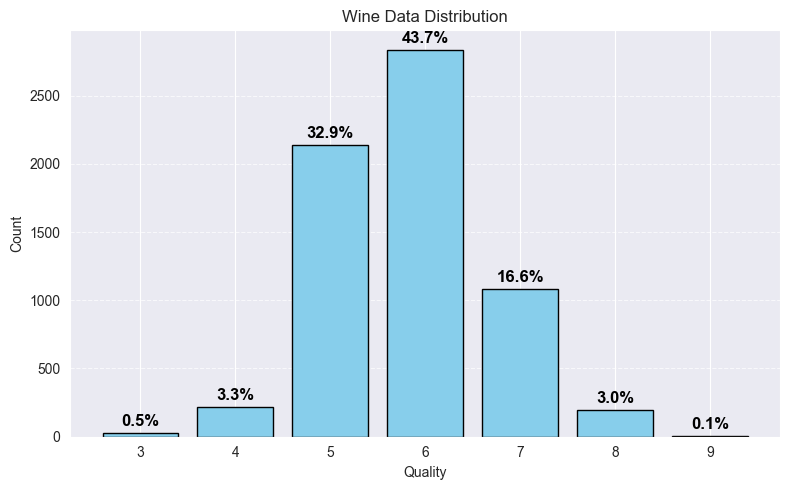

In [21]:
y = df['quality']

# Count and ratio
counts = y.value_counts().sort_index()
ratios = counts / counts.sum()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

# Add percentage labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ratio = ratios.iloc[i]
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 30,
        f"{ratio:.1%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'  # Force pure white
    )


# Titles and axes
plt.title("Wine Data Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.xticks(counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [22]:
# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Separate rare classes (e.g., <10 samples)
y_series = pd.Series(y_train).reset_index(drop=True)
X_df = pd.DataFrame(X_train_scaled).reset_index(drop=True)

class_counts = y_series.value_counts()
rare_classes = class_counts[class_counts < 1000].index.tolist()

# 4. Split training data: SMOTE-safe vs rare
mask = ~y_series.isin(rare_classes)
X_safe = X_df[mask].values
y_safe = y_series[mask].values

X_rare = X_df[~mask].values
y_rare = y_series[~mask].values

# 5. Apply SMOTE on SMOTE-safe subset only
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_safe, y_safe)

# 6. Combine all: original + resampled
X_train_final = np.vstack([X_train_scaled, X_smote])
y_train_final = np.hstack([y_train, y_smote])


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [23]:
clf = TabNetClassifier()

clf.fit(
    X_train=X_train_final, y_train=y_train_final,
    eval_set=[(X_test_scaled, y_test)],  # ✅ No filtering needed
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    virtual_batch_size=256,
    num_workers=0,
    drop_last=False
)


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.66347 | test_accuracy: 0.45385 |  0:00:00s
epoch 1  | loss: 1.14739 | test_accuracy: 0.50231 |  0:00:00s
epoch 2  | loss: 1.04624 | test_accuracy: 0.51923 |  0:00:00s
epoch 3  | loss: 1.00194 | test_accuracy: 0.51308 |  0:00:01s
epoch 4  | loss: 0.97392 | test_accuracy: 0.51077 |  0:00:01s
epoch 5  | loss: 0.95446 | test_accuracy: 0.52154 |  0:00:01s
epoch 6  | loss: 0.93767 | test_accuracy: 0.51231 |  0:00:01s
epoch 7  | loss: 0.93484 | test_accuracy: 0.53077 |  0:00:02s
epoch 8  | loss: 0.92411 | test_accuracy: 0.54154 |  0:00:02s
epoch 9  | loss: 0.91943 | test_accuracy: 0.53385 |  0:00:02s
epoch 10 | loss: 0.91601 | test_accuracy: 0.53    |  0:00:02s
epoch 11 | loss: 0.9096  | test_accuracy: 0.52769 |  0:00:03s
epoch 12 | loss: 0.90299 | test_accuracy: 0.53    |  0:00:03s
epoch 13 | loss: 0.90351 | test_accuracy: 0.53385 |  0:00:03s
epoch 14 | loss: 0.89515 | test_accuracy: 0.53846 |  0:00:03s
epoch 15 | loss: 0.89009 | test_accuracy: 0.53846 |  0:00:04s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


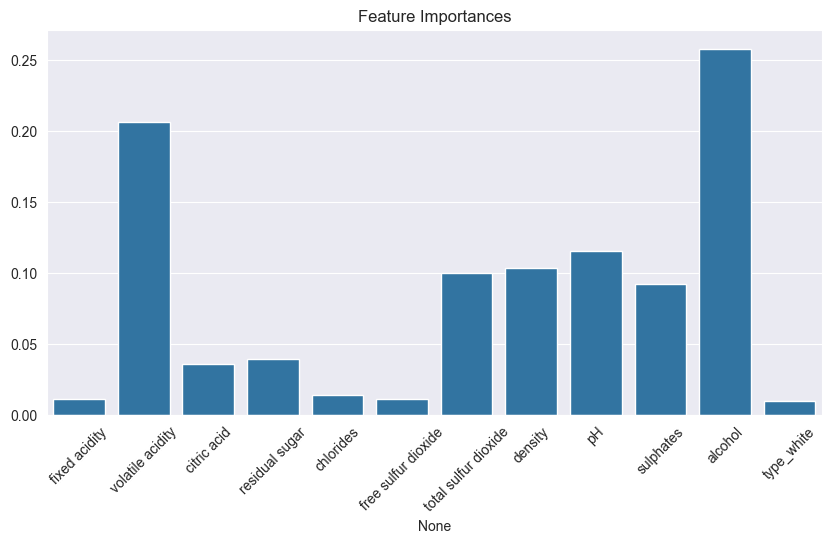

In [24]:
# Feature importance
feature_importances = clf.feature_importances_

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=X.columns, y=feature_importances)
plt.xticks(rotation=45)
plt.title('Feature Importances')
plt.show()

In [25]:
import pandas as pd

# Convert to DataFrame for easy filtering (if needed)
df_full = pd.DataFrame(X)  # or your full data
df_full['target'] = y      # add target column

# Keep only rows where target is 5, 6, or 7
df_filtered = df_full[df_full['target'].isin([5, 6, 7])]

# Split back into X and y
X_filtered = df_filtered.drop(columns='target').values
y_filtered = df_filtered['target'].values


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = TabNetClassifier(
)

clf.fit(
    X_train=X_train_scaled, y_train=y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    virtual_batch_size=128,
    max_epochs=100,
    patience=10,
    batch_size=512,
    num_workers=0,
    drop_last=False,
)


epoch 0  | loss: 1.61125 | test_accuracy: 0.44013 |  0:00:00s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 1.07656 | test_accuracy: 0.45169 |  0:00:00s
epoch 2  | loss: 1.04399 | test_accuracy: 0.46986 |  0:00:00s
epoch 3  | loss: 1.00557 | test_accuracy: 0.48637 |  0:00:00s
epoch 4  | loss: 0.95546 | test_accuracy: 0.50537 |  0:00:00s
epoch 5  | loss: 0.9185  | test_accuracy: 0.50702 |  0:00:01s
epoch 6  | loss: 0.8979  | test_accuracy: 0.53014 |  0:00:01s
epoch 7  | loss: 0.89564 | test_accuracy: 0.53014 |  0:00:01s
epoch 8  | loss: 0.87997 | test_accuracy: 0.52931 |  0:00:01s
epoch 9  | loss: 0.87315 | test_accuracy: 0.54996 |  0:00:01s
epoch 10 | loss: 0.86498 | test_accuracy: 0.54748 |  0:00:01s
epoch 11 | loss: 0.85979 | test_accuracy: 0.545   |  0:00:02s
epoch 12 | loss: 0.85528 | test_accuracy: 0.55822 |  0:00:02s
epoch 13 | loss: 0.85488 | test_accuracy: 0.54831 |  0:00:02s
epoch 14 | loss: 0.85426 | test_accuracy: 0.55078 |  0:00:02s
epoch 15 | loss: 0.8389  | test_accuracy: 0.564   |  0:00:02s
epoch 16 | loss: 0.83169 | test_accuracy: 0.55904 |  0:00:02s
epoch 17

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [28]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Optional: show new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))


Resampled class distribution: Counter({np.int64(5): 2269, np.int64(6): 2269, np.int64(7): 2269})


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [29]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
clf = TabNetClassifier(
)

# Train
clf.fit(
    X_train=X_train_resampled, y_train=y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=512,
    num_workers=0,
    drop_last=False,
)


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40118 | test_accuracy: 0.40628 |  0:00:00s
epoch 1  | loss: 1.04188 | test_accuracy: 0.44839 |  0:00:00s
epoch 2  | loss: 0.98372 | test_accuracy: 0.46656 |  0:00:00s
epoch 3  | loss: 0.93385 | test_accuracy: 0.46243 |  0:00:00s
epoch 4  | loss: 0.89066 | test_accuracy: 0.48059 |  0:00:01s
epoch 5  | loss: 0.88033 | test_accuracy: 0.48555 |  0:00:01s
epoch 6  | loss: 0.85977 | test_accuracy: 0.47812 |  0:00:01s
epoch 7  | loss: 0.85159 | test_accuracy: 0.48555 |  0:00:01s
epoch 8  | loss: 0.84183 | test_accuracy: 0.48059 |  0:00:02s
epoch 9  | loss: 0.82967 | test_accuracy: 0.52023 |  0:00:02s
epoch 10 | loss: 0.8258  | test_accuracy: 0.50784 |  0:00:02s
epoch 11 | loss: 0.82887 | test_accuracy: 0.49876 |  0:00:02s
epoch 12 | loss: 0.81721 | test_accuracy: 0.4905  |  0:00:02s
epoch 13 | loss: 0.81463 | test_accuracy: 0.5161  |  0:00:03s
epoch 14 | loss: 0.80345 | test_accuracy: 0.51693 |  0:00:03s
epoch 15 | loss: 0.80302 | test_accuracy: 0.51528 |  0:00:03s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import balanced_accuracy_score

class TabNetSklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.0, lambda_sparse=1e-4, lr=2e-2):
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse
        self.lr = lr
        self.model_ = None

    def fit(self, X, y):
        self.model_ = TabNetClassifier(
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            lambda_sparse=self.lambda_sparse,
            optimizer_params=dict(lr=self.lr),
            seed=42,
            verbose=0
        )
        self.model_.fit(
            X_train=X, y_train=y,
            eval_set=[(X, y)],
            eval_name=['train'],
            eval_metric=['accuracy'],
            max_epochs=100,
            patience=10,
            batch_size=512,
            virtual_batch_size=256,
            num_workers=0,
            drop_last=False
        )
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def score(self, X, y):
        return balanced_accuracy_score(y, self.predict(X))


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_d': [8, 16],
    'n_a': [8, 16],
    'n_steps': [3, 5],
    'gamma': [1.0, 1.5],
    'lambda_sparse': [1e-4, 1e-3],
}

grid = GridSearchCV(
    estimator=TabNetSklearnWrapper(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1  # TabNet uses GPU/CPU internally, use 1 to avoid overload
)

grid.fit(X_train_resampled, y_train_resampled)


Fitting 3 folds for each of 32 candidates, totalling 96 fits

Early stopping occurred at epoch 82 with best_epoch = 72 and best_train_accuracy = 0.76443
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=3; total time=  12.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_train_accuracy = 0.70626
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=3; total time=   7.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 47 and best_train_accuracy = 0.64963
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=3; total time=   8.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_train_accuracy = 0.70273
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=5; total time=   8.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 56 and best_train_accuracy = 0.71485
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=5; total time=  14.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_train_accuracy = 0.63222
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=5; total time=   8.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_train_accuracy = 0.73843
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=3; total time=   6.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 67 with best_epoch = 57 and best_train_accuracy = 0.75408
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=3; total time=  12.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_train_accuracy = 0.68312
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=3; total time=  10.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_train_accuracy = 0.7338
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=5; total time=  12.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 72 and best_train_accuracy = 0.75606
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=5; total time=  27.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_train_accuracy = 0.62847


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=5; total time=  14.0s

Early stopping occurred at epoch 58 with best_epoch = 48 and best_train_accuracy = 0.77523
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=3; total time=  15.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 47 and best_train_accuracy = 0.74945
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=3; total time=  12.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 93 with best_epoch = 83 and best_train_accuracy = 0.7089
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=3; total time=  18.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 65 and best_train_accuracy = 0.77589
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=5; total time=  22.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_train_accuracy = 0.67364
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=5; total time=   7.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_train_accuracy = 0.61723
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=5; total time=  11.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_train_accuracy = 0.83164
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=3; total time=  23.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 88 with best_epoch = 78 and best_train_accuracy = 0.77788
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=3; total time=  20.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 45 and best_train_accuracy = 0.6721
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=3; total time=  12.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 53 and best_train_accuracy = 0.75716
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=5; total time=  21.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_train_accuracy = 0.71816
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=5; total time=  15.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_train_accuracy = 0.64235
[CV] END gamma=1.0, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=5; total time=  11.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_train_accuracy = 0.78052
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=3; total time=  17.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 50 and best_train_accuracy = 0.73535
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=3; total time=  11.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 81 and best_train_accuracy = 0.6851
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=3; total time=  16.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_train_accuracy = 0.69546
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=5; total time=  10.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_train_accuracy = 0.72234
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=5; total time=  13.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 55 and best_train_accuracy = 0.66086
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=5; total time=  17.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 38 and best_train_accuracy = 0.74901
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=3; total time=   9.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_train_accuracy = 0.72962
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=3; total time=   7.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 56 and best_train_accuracy = 0.6829
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=3; total time=  11.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_train_accuracy = 0.72168
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=5; total time=  10.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_train_accuracy = 0.73138
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=5; total time=  10.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_train_accuracy = 0.64522
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=5; total time=  11.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_train_accuracy = 0.74791
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=3; total time=   6.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_train_accuracy = 0.72565
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=3; total time=   7.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 92 and best_train_accuracy = 0.70824
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=3; total time=  16.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_train_accuracy = 0.72389
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=5; total time=  10.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 48 and best_train_accuracy = 0.71441
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=5; total time=  14.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_train_accuracy = 0.64301
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=5; total time=   8.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 64 with best_epoch = 54 and best_train_accuracy = 0.76421
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=3; total time=  11.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_train_accuracy = 0.71375
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=3; total time=   6.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 77 with best_epoch = 67 and best_train_accuracy = 0.6937
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=3; total time=  13.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_train_accuracy = 0.73402
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=5; total time=  14.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_train_accuracy = 0.70097
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=5; total time=  11.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_train_accuracy = 0.65051
[CV] END gamma=1.0, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=5; total time=  10.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 61 and best_train_accuracy = 0.72345
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=3; total time=  10.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_train_accuracy = 0.69458
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=3; total time=   6.9s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 93 with best_epoch = 83 and best_train_accuracy = 0.658
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=3; total time=  13.9s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_train_accuracy = 0.65844
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=5; total time=   6.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_train_accuracy = 0.63618
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=5; total time=   7.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_train_accuracy = 0.6093
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=5; total time=   7.9s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 72 with best_epoch = 62 and best_train_accuracy = 0.7413
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=3; total time=  12.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 49 and best_train_accuracy = 0.72543
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=3; total time=  10.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 40 and best_train_accuracy = 0.65403
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=3; total time=   8.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_train_accuracy = 0.67541
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=5; total time=  10.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_train_accuracy = 0.67166
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=5; total time=  12.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_train_accuracy = 0.61657
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=8, n_d=16, n_steps=5; total time=  11.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_train_accuracy = 0.71639
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=3; total time=   7.9s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 33 and best_train_accuracy = 0.70714
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=3; total time=   7.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_train_accuracy = 0.69282
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=3; total time=  16.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_train_accuracy = 0.68665
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=5; total time=  12.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_train_accuracy = 0.64279
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=5; total time=   8.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_train_accuracy = 0.60004
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=8, n_steps=5; total time=   7.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_train_accuracy = 0.79793
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=3; total time=  18.0s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_train_accuracy = 0.72499
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=3; total time=   9.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_train_accuracy = 0.65954
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=3; total time=   8.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_train_accuracy = 0.66549
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=5; total time=   9.2s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 53 and best_train_accuracy = 0.67629
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=5; total time=  16.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_train_accuracy = 0.59079
[CV] END gamma=1.5, lambda_sparse=0.0001, n_a=16, n_d=16, n_steps=5; total time=   6.3s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_train_accuracy = 0.75121
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=3; total time=  14.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 33 and best_train_accuracy = 0.6818
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=3; total time=   6.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_train_accuracy = 0.61877
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=3; total time=   3.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 45 and best_train_accuracy = 0.67254
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=5; total time=  12.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_train_accuracy = 0.66175
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=5; total time=  10.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_train_accuracy = 0.60115
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=5; total time=   6.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 87 with best_epoch = 77 and best_train_accuracy = 0.79396
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=3; total time=  14.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_train_accuracy = 0.78581
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=3; total time=  16.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_train_accuracy = 0.66373
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=3; total time=   8.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_train_accuracy = 0.65139
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=5; total time=   8.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_train_accuracy = 0.66351
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=5; total time=   8.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_train_accuracy = 0.60798
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=8, n_d=16, n_steps=5; total time=  11.6s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_train_accuracy = 0.79815
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=3; total time=  16.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_train_accuracy = 0.7175
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=3; total time=   8.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_train_accuracy = 0.69766
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=3; total time=  16.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 38 and best_train_accuracy = 0.68158
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=5; total time=  11.9s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_train_accuracy = 0.64213
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=5; total time=   7.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_train_accuracy = 0.58947
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=8, n_steps=5; total time=   7.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_train_accuracy = 0.73072
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=3; total time=  11.7s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 72 and best_train_accuracy = 0.74747
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=3; total time=  16.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_train_accuracy = 0.70868
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=3; total time=  20.1s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_train_accuracy = 0.67651
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=5; total time=  14.8s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_train_accuracy = 0.64412
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=5; total time=   8.4s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_train_accuracy = 0.59674
[CV] END gamma=1.5, lambda_sparse=0.001, n_a=16, n_d=16, n_steps=5; total time=   8.5s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_train_accuracy = 0.70339


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


GridSearchCV(cv=3, estimator=TabNetSklearnWrapper(), n_jobs=1,
             param_grid={'gamma': [1.0, 1.5], 'lambda_sparse': [0.0001, 0.001],
                         'n_a': [8, 16], 'n_d': [8, 16], 'n_steps': [3, 5]},
             scoring='accuracy', verbose=2)

In [32]:
import pandas as pd

# Convert cv_results_ to DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Optional: select relevant columns
columns_to_keep = [
    'mean_test_score', 'std_test_score', 'rank_test_score',
    'param_n_d', 'param_n_a', 'param_n_steps',
    'param_gamma', 'param_lambda_sparse'
]

results_df = results_df[columns_to_keep]

# Save to CSV
results_df.to_csv("tabnet_wine_results_smote.csv", index=False)

print("✅ Grid search results saved to 'tabnet_wine_results_smote.csv'")


✅ Grid search results saved to 'tabnet_wine_results_smote.csv'


In [33]:
results_df

,mean_test_score,std_test_score,rank_test_score,param_n_d,param_n_a,param_n_steps,param_gamma,param_lambda_sparse
0,0.534891,0.013845,14,8,8,3,1.0,0.0001
1,0.523872,0.031847,20,8,8,5,1.0,0.0001
2,0.554723,0.034651,10,16,8,3,1.0,0.0001
3,0.514764,0.062844,22,16,8,5,1.0,0.0001
4,0.603056,0.036158,1,8,16,3,1.0,0.0001
5,0.519318,0.040619,21,8,16,5,1.0,0.0001
6,0.563097,0.040228,5,16,16,3,1.0,0.0001
7,0.533862,0.023327,17,16,16,5,1.0,0.0001
8,0.564566,0.003298,4,8,8,3,1.0,0.0010
9,0.534450,0.007342,15,8,8,5,1.0,0.0010


In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Use the best model
best_model = grid.best_estimator_

# Predict on original test set
y_pred = best_model.predict(X_test_scaled)

# Evaluate
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Test Accuracy: 0.5623451692815855
📊 Classification Report:
               precision    recall  f1-score   support

           5       0.66      0.62      0.64       428
           6       0.59      0.47      0.52       567
           7       0.42      0.69      0.52       216

    accuracy                           0.56      1211
   macro avg       0.56      0.59      0.56      1211
weighted avg       0.58      0.56      0.56      1211



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_d': [8, 16],
    'n_a': [8, 16],
    'n_steps': [3, 5],
    'gamma': [1.0, 1.5],
    'lambda_sparse': [1e-4, 1e-3],
}

grid = GridSearchCV(
    estimator=TabNetSklearnWrapper(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1  # TabNet uses GPU/CPU internally, use 1 to avoid overload
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
